__Imports__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import tensorflow_datasets as tfds

### Load in the data__
* Splits the data
* Shuffle the data

__Batch_size=-1 to get the full dataset in NumPy arrays from the returned tf.Tensor object__

In [2]:
mnist_test,mnist_val,mnist_train = tfds.load(name="mnist_corrupted/impulse_noise",
                                             split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
                                             batch_size=-1,
                                             shuffle_files=True
                                            ) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Michael\tensorflow_datasets\mnist_corrupted\impulse_noise\1.0.0.incomplete6BOK83\mnist_corr…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Michael\tensorflow_datasets\mnist_corrupted\impulse_noise\1.0.0.incomplete6BOK83\mnist_corr…

Dataset mnist_corrupted downloaded and prepared to C:\Users\Michael\tensorflow_datasets\mnist_corrupted\impulse_noise\1.0.0. Subsequent calls will reuse this data.


__tfds.as_numpy return a generator that yields NumPy array records out of a tf.data.Dataset__

In [3]:
# tfds.as_numpy return a generator that yields NumPy array records out of a tf.data.Dataset
mnist_train = tfds.as_numpy(mnist_train) 
mnist_val = tfds.as_numpy(mnist_val) 
mnist_test = tfds.as_numpy(mnist_test)

__Seperate the x and y__

In [4]:
x_train, y_train = mnist_train["image"], mnist_train["label"]
x_valid,y_valid = mnist_val["image"], mnist_val["label"]
x_test, y_test = mnist_test["image"], mnist_test["label"]

__Check lengths__

In [5]:
print("Train set size: ", len(x_train))
print("Valid set size: ", len(x_valid))
print("Test set size: ", len(x_test))

Train set size:  45000
Valid set size:  9000
Test set size:  6000


__Data Normalization__

In [6]:
# Normalize values
x_train = x_train/255
x_valid = x_valid/255
x_test = x_test/255

__Visualize the Data__

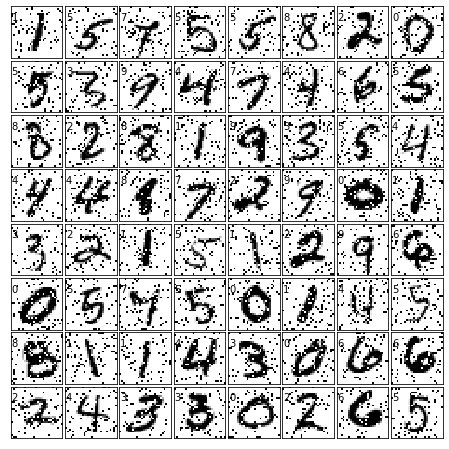

In [7]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train[i]))

### Processing Data

__Accuracy Function__

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

__Always a good habit to randomized seeds__

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

__Autoencoder Model__

__Encoder__

In [10]:
denoising_encoder = keras.models.Sequential([
 keras.layers.Reshape( [28, 28, 1], input_shape=[28,28] ),
 keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation='selu', padding='same'),
 keras.layers.MaxPooling2D(pool_size = (2, 2),strides=(2,2),padding='valid'),
 keras.layers.GaussianNoise(0.3),
 keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='selu', padding='same'),
 keras.layers.MaxPooling2D(pool_size = (2, 2),strides=(2,2),padding='same'),
 keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='selu', padding='same'),
 keras.layers.MaxPooling2D(pool_size = (2, 2),strides=(2,2),padding='same'),
 keras.layers.GaussianNoise(0.3),
 keras.layers.Flatten(),
 keras.layers.Dense(256, activation="selu"),
 keras.layers.GaussianNoise(0.5),
 keras.layers.Dense(28*28, activation="selu"),
 keras.layers.Reshape( [28, 28,1] )

])

__Decoder__

In [11]:
denoising_decoder = keras.models.Sequential([
 keras.layers.Conv2DTranspose(8, kernel_size = 3, activation='selu', padding='valid',input_shape=[28,28,1]),
#  keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu" ), 
#  keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding="SAME", activation="selu" ), 
 keras.layers.MaxPool2D((2, 2)),
 keras.layers.Flatten(),
 keras.layers.Dense(512, activation="selu", input_shape=[30]),
 keras.layers.Dense(256,activation='selu'),
 keras.layers.Dense(128,activation='selu'),
 keras.layers.Dense(28 * 28, activation="sigmoid"),
 keras.layers.Reshape([28, 28])
])

__Now connect them together__

In [12]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
 metrics=[rounded_accuracy])

__Using x_train as both the inputs and the targets and similarly, we use x_valid as both the validation inputs and targets__


In [13]:
history = denoising_ae.fit(x_train, x_train, epochs=20,
 validation_data=(x_valid, x_valid))

Epoch 1/20
1407/1407 [==============================] - 11s 4ms/step - loss: 0.4200 - rounded_accuracy: 0.8194 - val_loss: 0.3902 - val_rounded_accuracy: 0.8484
Epoch 2/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3773 - rounded_accuracy: 0.8582 - val_loss: 0.3682 - val_rounded_accuracy: 0.8659
Epoch 3/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3635 - rounded_accuracy: 0.8690 - val_loss: 0.3617 - val_rounded_accuracy: 0.8709
Epoch 4/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3563 - rounded_accuracy: 0.8740 - val_loss: 0.3567 - val_rounded_accuracy: 0.8729
Epoch 5/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3515 - rounded_accuracy: 0.8768 - val_loss: 0.3518 - val_rounded_accuracy: 0.8763
Epoch 6/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3479 - rounded_accuracy: 0.8787 - val_loss: 0.3487 - val_rounded_accuracy: 0.8788
Epoch 7/20
1407/1407 [=================

### Reconstruction Zone & Analysis

__Function to show plots__

In [14]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

__Function to Reconstruction Images given a model__

In [15]:
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


__Top is Original & Bottom is Reconstructed__

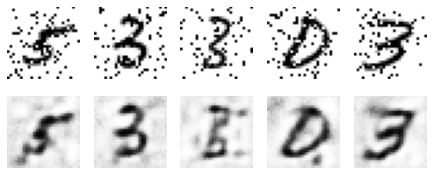

In [16]:
show_reconstructions(denoising_ae)

__Analysis__

__t-SNE is based on probability distributions with random walk on neighborhood graphs to find the structure
within the data.__

In [17]:
np.random.seed(42)
from sklearn.manifold import TSNE
X_valid_compressed = denoising_ae.predict(x_valid)
nsamples, nx, ny = X_valid_compressed.shape
X_valid_compressed = X_valid_compressed.reshape((nsamples,nx*ny))
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

C:\Users\Michael\miniconda3\envs\py3_base\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Michael\miniconda3\envs\py3_base\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


__t-SNE Plot__

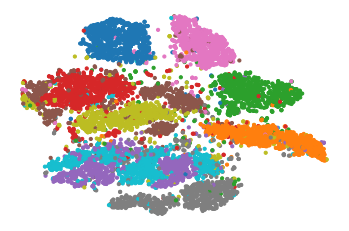

In [18]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

__t-SNE with Images__

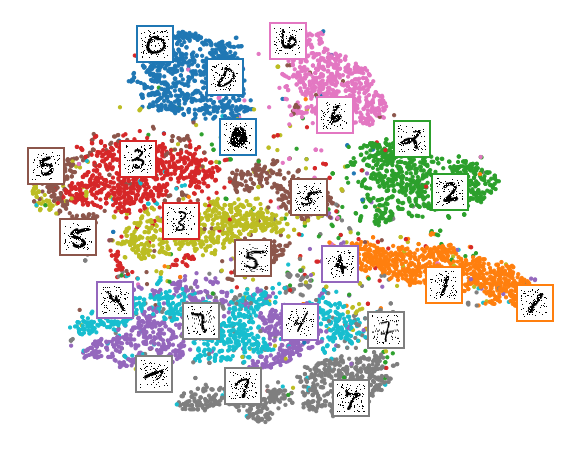

In [19]:
import matplotlib as mpl
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(x_valid[index], cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
    plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()
